<div class="alert alert-block alert-info">
This notebook is for exploratory analysis of Joey Yung's album tracks. <br>
The data exclude Singles and EPs.
</div>

## Import libraries and set up

In [ ]:
import pandas as pd
import numpy as np
import sys

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%config InlineBackend.figure_format = 'svg' 
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'

In [ ]:
my_color = {
    'light_blue': '#7FB3D5'
}

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from authorization import username, cid, secret

scope = (
    'playlist-modify-public '
    'user-library-read '
    'user-follow-read '
    'user-library-modify '
    'user-read-private '
    'user-top-read '
    'user-follow-modify '
    'user-read-recently-played '
    'ugc-image-upload '
    'user-read-playback-state '
)

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(cid, secret),
                     auth_manager=SpotifyOAuth(client_id=cid, 
                                               client_secret=secret, 
                                               redirect_uri='http://localhost:1234/chenyun/', 
                                               username=username, 
                                               scope=scope))

## Load master data of Joey Yung's tracks (notebook 200)

In [5]:
df_all = pd.read_parquet('data/joey_yung_album_tracks_asof_20200510.parquet')

In [6]:
# # de-dup by "name" and keep the top popular one
# df_dedup = df_all.sort_values(by='popularity', ascending=False).drop_duplicates('name').sort_index()
# df_all.shape, df_dedup.shape

In [6]:
# Let's focus on analyzing the data before de-dup
df = df_all.copy()

In [7]:
df.sample(2)

,album,track_number,name,uri,available_markets,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,time_signature,album_uris,album_release_date,album_release_date_precision,album_total_trakcs
788,一個人的情歌,8,漂白的心,spotify:track:2a6cNibIPruArmCjeWUK8I,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",222559,0.604,0.482,0.502,0.0,0.1180,-8.513,0.0322,134.026,0.372,5,2,1,4,spotify:album:1HZqCFbUCR8UPgGsqgjPS5,2002-10-11,day,10
191,All Delicious Collection,4,13點,spotify:track:69lwH212VGEyOBOEzkurjR,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",242586,0.589,0.653,0.544,0.0,0.0887,-7.481,0.0550,150.055,0.587,11,4,1,4,spotify:album:2iSlwjxrjnnEFLgO9rAtbN,2013-12-20,day,34


## Exploratory data analysis

### Albums: Number of albums released by year

🤔 On average, Joey released 1 or 2 albums every year. She had some EPs/Singles released in recent years but not captured here.

In [8]:
df['album_release_year'] = df['album_release_date'].apply(lambda x: int(x[:4]))

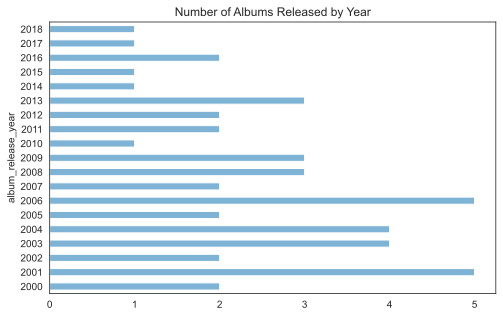

In [9]:
df.groupby('album_release_year')['album'].nunique().plot(kind='barh', color=my_color['light_blue'])
plt.title('Number of Albums Released by Year');

🤔 We are more likely to expect a new album coming out between June and January than between February and May.

In [10]:
df_albums = df[df.album_release_date_precision=='day'][['album', 'album_release_date']].drop_duplicates()
df_albums['album_release_month'] = pd.to_datetime(df_albums['album_release_date'], format='%Y-%m-%d').dt.month

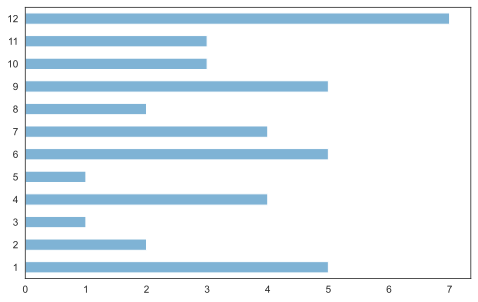

In [11]:
df_albums.album_release_month.value_counts().sort_index().plot(kind='barh', color=my_color['light_blue']);

### Albums: Popularity

The popularity is calculated from the popularity of the album’s individual tracks.<br>
[According to Sportify](https://developer.spotify.com/documentation/web-api/reference-beta/#objects-index), the `popularity` of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.
---

In [12]:
df['album_popularity'] = df.groupby('album').popularity.transform('mean')

In [13]:
top_albums = (df[['album', 'album_release_year', 'album_popularity']]
              .drop_duplicates()
              .sort_values(by='album_popularity', ascending=False)
              .head()
             )
top_albums

,album,album_release_year,album_popularity
222,Hopelessly Romantic Collection,2013,33.057143
481,喜歡祖兒4 (新曲 + 精選),2007,24.090909
94,Joey Yung X Hacken Lee Concert 2015 (Live),2015,19.981818
10,Joey • My Secret • Live,2017,19.487805
0,答案之書,2018,18.300000


In [14]:
top_tracks_in_top_albums = (df[df.album.isin(top_albums.album)]
                            .sort_values(by=['album', 'popularity'], ascending=False)
                            .groupby('album').head(5)[['album', 'name', 'popularity', 'album_popularity', 'uri']]
                            .sort_values('album_popularity', ascending=False)
                           )
top_tracks_in_top_albums

,album,name,popularity,album_popularity,uri
246,Hopelessly Romantic Collection,怯,39,33.057143,spotify:track:58AfuE1QTEt30NWq2N1XJh
254,Hopelessly Romantic Collection,習慣失戀,40,33.057143,spotify:track:31GJNXN98ME15oFBi82cSd
253,Hopelessly Romantic Collection,痛愛,46,33.057143,spotify:track:3QSh37f3Sp4SjG4hOtsRTf
222,Hopelessly Romantic Collection,續集 - TVB電視劇「On Call 36小時II」主題曲,49,33.057143,spotify:track:1XtiDdJZjP91neZyMPknOr
256,Hopelessly Romantic Collection,連續劇,50,33.057143,spotify:track:6RVBDN9xXQ6rl4S0woH33O
498,喜歡祖兒4 (新曲 + 精選),16 號愛人,47,24.090909,spotify:track:3xtD4lxez1FVIOftA4fcpD
494,喜歡祖兒4 (新曲 + 精選),爭氣,43,24.090909,spotify:track:4fDRUT7ZwyDXrfFAAtdR6F
511,喜歡祖兒4 (新曲 + 精選),痛愛,42,24.090909,spotify:track:0StuO1Spn9uXwcnR8R523C
485,喜歡祖兒4 (新曲 + 精選),天之驕女,35,24.090909,spotify:track:70lvSUvM5AouTLslqCZfKu
495,喜歡祖兒4 (新曲 + 精選),告解,35,24.090909,spotify:track:3gdMvXmQtPQsb51701lkdO


In [15]:
new_playlist = sp.user_playlist_create(username, 'joey_test') # create playlist and add tracks

In [16]:
sp.user_playlist_add_tracks(username, playlist_id=new_playlist['id'], tracks=list(top_tracks_in_top_albums.uri))

{'snapshot_id': 'MyxlOTM5ZDRiY2YzYzFiMjVmMTI1ZTViMTM1NDI4Njg4YWNkMTliOGU5'}

### Tracks: Popularity

🤔 Based on the description of **popularity**, songs that played a lot now will have a higher popularity than songs that were played a lot in the past. Here, however, we can see most popular songs are released in year 2013 or even earlier. Fans seems to be more attracted by relatively older songs.

In [21]:
df.sort_values(by='popularity', ascending=False).head(30)[['album', 'name', 'album_release_year']].set_index('album')

,name,album_release_year
album,,
我的驕傲,心淡,2003
Hopelessly Romantic Collection,連續劇,2013
Hopelessly Romantic Collection,續集 - TVB電視劇「On Call 36小時II」主題曲,2013
一百個我 國語新曲+精選,這就是愛嗎?,2016
喜歡祖兒4 (新曲 + 精選),16 號愛人,2007
Hopelessly Romantic Collection,痛愛,2013
喜歡祖兒4 (新曲 + 精選),爭氣,2007
喜歡祖兒4 (新曲 + 精選),痛愛,2007
我的驕傲,我的驕傲,2003


Let's first take a look at the distribution of tracks popularity. Seems some tracks are way more popular than others.

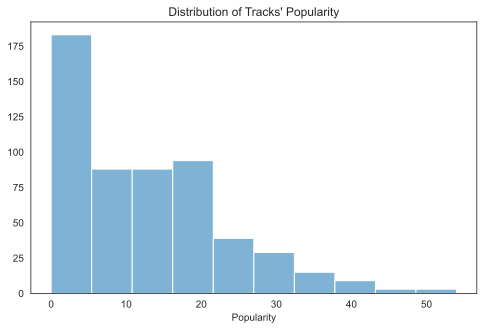

In [9]:
plt.hist(df.popularity, color=my_color['light_blue'])
plt.title("Distribution of Tracks' ZZZZPopularity")
plt.xlabel('Popularity');

In [16]:
df.sort_values(by='popularity', ascending=False).head(30)[['album', 'name', 'popularity', 'album_release_year']]

,album,name,popularity,album_release_year
754,我的驕傲,心淡,54,2003
256,Hopelessly Romantic Collection,連續劇,50,2013
222,Hopelessly Romantic Collection,續集 - TVB電視劇「On Call 36小時II」主題曲,49,2013
76,一百個我 國語新曲+精選,這就是愛嗎?,48,2016
498,喜歡祖兒4 (新曲 + 精選),16 號愛人,47,2007
253,Hopelessly Romantic Collection,痛愛,46,2013
494,喜歡祖兒4 (新曲 + 精選),爭氣,43,2007
511,喜歡祖兒4 (新曲 + 精選),痛愛,42,2007
758,我的驕傲,我的驕傲,42,2003
254,Hopelessly Romantic Collection,習慣失戀,40,2013


### Do popular songs have any characteristics based on audio features?

<div class="alert alert-block alert-warning">
Please refer to the README to see feature descriptions.
</div>

There are ~25% of tracks have popularity less than 5, maybe not too many people have listened to them yet. Let's exclude them for now.

In [12]:
df.shape
df = df[df.popularity >= 5]
df.shape # We lost about 160 dps

(551, 23)

(391, 23)

Here's the updated distribution of popularity.

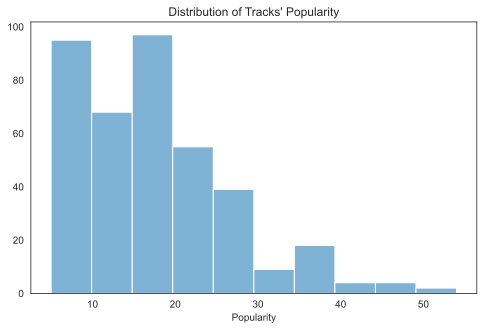

In [13]:
plt.hist(df.popularity, color=my_color['light_blue'])
plt.title("Distribution of Tracks' Popularity")
plt.xlabel('Popularity');

In [14]:
popularity_cutoff = df.popularity.quantile(0.8)
df['popularity_category'] = np.where(df.popularity >= popularity_cutoff, 'most popular songs', 'others')

In [15]:
popularity_cutoff
df.popularity_category.value_counts()

24.0

others                312
most popular songs     79
Name: popularity_category, dtype: int64

In [16]:
df.groupby('popularity_category')[list(df.columns[6:len(df.columns)-5])].mean().T

popularity_category,most popular songs,others
acousticness,0.566765,0.430160
danceability,0.543076,0.546747
energy,0.465759,0.575386
instrumentalness,0.000005,0.015234
liveness,0.211976,0.370530
loudness,-8.430367,-8.279173
speechiness,0.041994,0.068596
tempo,129.508291,121.892465
valence,0.347937,0.417873
popularity,31.949367,13.551282


In [17]:
df.groupby('mode')['popularity'].describe()

,count,mean,std,min,25%,50%,75%,max
mode,,,,,,,,
0,102.0,14.764706,8.785876,5.0,9.0,13.5,17.75,50.0
1,289.0,18.152249,9.430171,5.0,11.0,17.0,22.00,54.0


In [18]:
df.head()

,album,track_number,name,uri,available_markets,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,time_signature,album_uris,album_release_date,album_release_date_precision,album_total_trakcs,popularity_category
0,答案之書,1,優秀,spotify:track:1ZBUhpscaXX1Q35RmMBR4v,"[AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, CO, C...",217815,0.04430,0.581,0.849,0.000083,0.0642,-5.835,0.0353,128.136,0.402,18,9,1,4,spotify:album:0zPpdDiDX6JnGZRHXFYuZt,2018-10-19,day,10,others
1,答案之書,2,亞亞亞,spotify:track:2FKxsi0BDOZCYBSheFCb0f,"[AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, CO, C...",183077,0.00637,0.524,0.829,0.000087,0.0627,-5.081,0.0760,171.975,0.391,15,10,0,4,spotify:album:0zPpdDiDX6JnGZRHXFYuZt,2018-10-19,day,10,others
2,答案之書,3,綁夢,spotify:track:1fMPS7ewHOKFaMI0iDhntr,"[AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, CO, C...",200887,0.22900,0.411,0.606,0.000000,0.2270,-7.090,0.2330,74.411,0.510,15,1,1,5,spotify:album:0zPpdDiDX6JnGZRHXFYuZt,2018-10-19,day,10,others
3,答案之書,4,孤單喧嘩,spotify:track:0iyG2K02EtnTYkJAurcyT5,"[AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, CO, C...",260706,0.30700,0.528,0.451,0.000000,0.1010,-8.345,0.0395,73.059,0.427,18,0,1,4,spotify:album:0zPpdDiDX6JnGZRHXFYuZt,2018-10-19,day,10,others
4,答案之書,5,容光,spotify:track:5t0f2DIs0qMSjADpWxqDSB,"[AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, CO, C...",272364,0.86100,0.393,0.299,0.000000,0.0986,-11.124,0.0368,118.469,0.269,19,2,1,4,spotify:album:0zPpdDiDX6JnGZRHXFYuZt,2018-10-19,day,10,others


In [19]:
feature = 'valence'

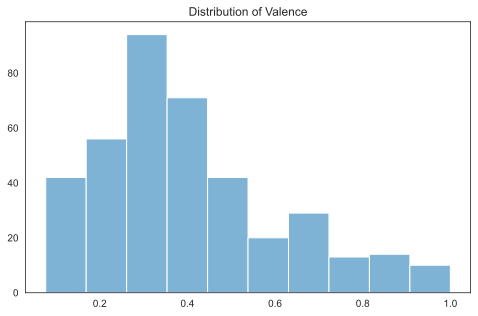

In [20]:
plt.hist(df[feature], color=my_color['light_blue'])
plt.title("Distribution of " + feature.capitalize());

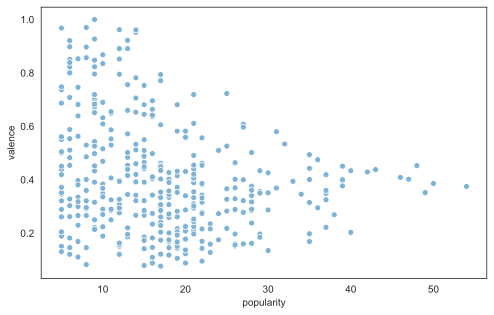

In [21]:
sns.scatterplot(x='popularity',
                y=feature,
                data=df,
                color=my_color['light_blue']);

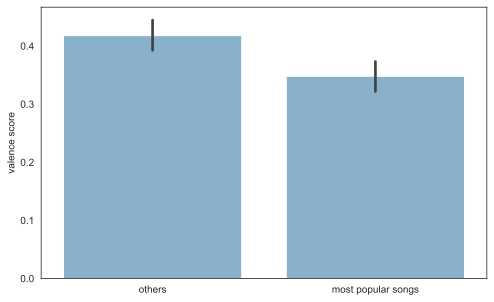

In [22]:
sns.barplot(x='popularity_category', 
            y=feature, 
            data=df,
            color=my_color['light_blue'])
plt.xlabel('')
plt.ylabel(feature + ' score');